In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from operator import itemgetter

In [2]:
df = pd.read_csv('CHEMBL3888506.tsv', sep='\t', header=0)

In [3]:
df.head(2)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID
0,CHEMBL3974692,NaN,0,635.12,2,6.34,BDBM232633,Nc1nn2cccnc2c1C(=O)Nc3cn(nc3c4cc(Cl)ccc4OC(F)F...,Ki,'=',...,CHEMBL2971,Tyrosine-protein kinase JAK2,Homo sapiens,SINGLE PROTEIN,CHEMBL3886737,37,BindingDB Database,NaN,2016,NaN
1,CHEMBL3896141,NaN,0,585.02,1,3.65,BDBM232828,FC(F)Oc1ccc(Cl)cc1c2nn(CC(=O)N3CCN(CC4CC4)CC3)...,Ki,'=',...,CHEMBL2971,Tyrosine-protein kinase JAK2,Homo sapiens,SINGLE PROTEIN,CHEMBL3886737,37,BindingDB Database,NaN,2016,NaN


In [4]:
df.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID'],
      dtype='object')

In [5]:
mols = [Chem.MolFromSmiles(smi) for smi in df.Smiles]
sampleidx = np.random.choice(list(range(len(mols))), size=400, replace=False)
samplemols = [mols[i] for i in sampleidx]
sampleact = [9-np.log10(df['Standard Value'][idx]) for idx in sampleidx]

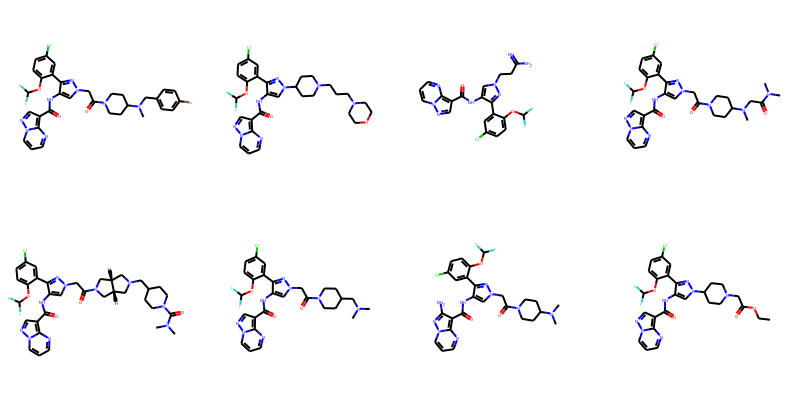

In [6]:
Draw.MolsToGridImage(samplemols[:8], molsPerRow=4)

In [7]:
fps = [AllChem.GetMorganFingerprintAsBitVect(m,2) for m in samplemols]

In [8]:
def fp2arr(fp):
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

In [9]:
X = np.asarray([fp2arr(fp) for fp in fps])

In [10]:
X.shape

(400, 2048)

In [11]:
# draw 60 x 60 grid space 
size = 20

In [12]:
N = size*size

In [13]:
data = PCA(n_components=100).fit_transform(X.astype(np.float32))
embeddings = TSNE(init='pca', random_state=794, verbose=2).fit_transform(data)
embeddings -= embeddings.min(axis=0)
embeddings /= embeddings.max(axis=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.009613
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 64.2904129, gradient norm = 0.5212628 (50 iterations in 0.077s)
[t-SNE] Iteration 100: error = 65.1731262, gradient norm = 0.5281700 (50 iterations in 0.086s)
[t-SNE] Iteration 150: error = 65.1265259, gradient norm = 0.5200158 (50 iterations in 0.082s)
[t-SNE] Iteration 200: error = 65.0476303, gradient norm = 0.4935639 (50 iterations in 0.075s)
[t-SNE] Iteration 250: error = 65.4537354, gradient norm = 0.4991030 (50 iterations in 0.081s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.453735
[t-SNE] Iteration 300: error = 0.5730352, gradient norm = 0.0037268 (50 iterations in 0.063s)
[t-SNE] Iteration 350: error = 0.4923524, gradient norm = 0.0011655 (

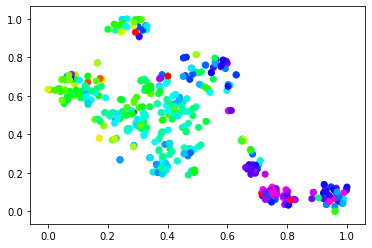

In [14]:
plt.scatter(embeddings[:,0], embeddings[:,1], c=sampleact, cmap='hsv')

In [15]:
grid = np.dstack(np.meshgrid(np.linspace(0,1,size), np.linspace(0,1,size))).reshape(-1,2)

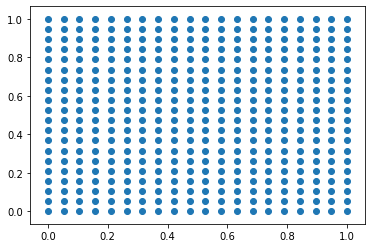

In [16]:
plt.scatter(grid[:,0], grid[:,1])

In [17]:
from lapjv import lapjv
print(embeddings.shape)

(400, 2)


In [18]:
cost_mat = cdist(grid, embeddings, 'sqeuclidean').astype(np.float32)
cost_mat2 = cost_mat * (10000 / cost_mat.max())
print(cost_mat2.shape)
print(grid.shape)

(400, 400)
(400, 2)


In [19]:
%time row_asses, col_asses, _ = lapjv(cost_mat2)

CPU times: user 982 ms, sys: 7.95 ms, total: 990 ms
Wall time: 205 ms


In [20]:
grid_lap = grid[col_asses]

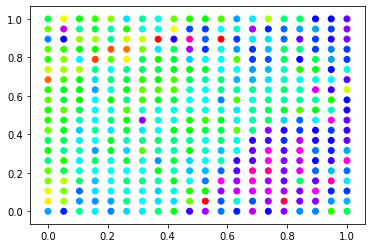

In [21]:
plt.scatter(grid_lap[:,0], grid_lap[:,1], c=sampleact, cmap='hsv')